<a href="https://colab.research.google.com/github/bf319/Scaling_MPNNs/blob/main/make_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install -q memory_profiler

In [32]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [33]:
import pandas as pd

roc_vs_number_of_params_url = "https://docs.google.com/spreadsheets/d/1vbInj1sfZU5Cgl5E12x3QX1th0JAajpUTFrVRAGNsa8/gviz/tq?tqx=out:csv&sheet=Sheet1"
roc_vs_batch_size = "https://docs.google.com/spreadsheets/d/10X0txNmMmY2sRbCMxPbn8dIGIiFAmlB55Osog-757uc/gviz/tq?tqx=out:csv&sheet=Sheet1"

roc_vs_number_of_partitions = "https://docs.google.com/spreadsheets/d/1iDc94xUGSDGsWSAUT4INu0M3IkHEiyN4tyhgIX9lgvk/gviz/tq?tqx=out:csv&sheet=Sheet1"

df_number_of_params = pd.read_csv(roc_vs_number_of_params_url)
df_batch_size = pd.read_csv(roc_vs_batch_size) # TODO: 1 row copied for 11500 epochs on 2 layers

df_partitions = pd.read_csv(roc_vs_number_of_partitions)

In [34]:
def compute_average_training_time():
  message_passing_steps_evaluated = [1, 2, 5, 10, 15]

  avg = []

  for num_message_passing_steps in message_passing_steps_evaluated:

    avg_for_mp = 0.0
    count = 0

    for index, row in df_batch_size.iterrows():
      if row['Message passing steps'] == num_message_passing_steps and row['Epoch'] < 11000:
        avg_for_mp += row['Running time']
        count += 1

    avg.append(round(avg_for_mp / count * 1000 / 500, 3))

  print(avg)

mem = %memit compute_average_training_time()

[252.09, 267.073, 336.092, 459.726, 512.08]
[252.09, 267.073, 336.092, 459.726, 512.08]
peak memory: 174.45 MiB, increment: 0.00 MiB


In [35]:
def compute_average_training_time_for_partitions():
  overall_partitions = [125, 110, 95, 80, 65]

  avg = []

  for partitions in overall_partitions:

    avg_for_mp = 0.0
    count = 0

    for index, row in df_partitions.iterrows():
      if row['Partitions'] == partitions and row['Epoch'] < 11000:
        avg_for_mp += row['Running time']
        count += 1

    avg.append(round(avg_for_mp / count * 1000 / 500, 3))

  print(avg)

compute_average_training_time_for_partitions()

[416.1, 477.097, 506.028, 583.491, 773.328]


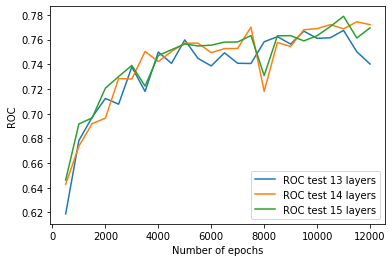

In [36]:
import matplotlib.pyplot as plt

def plot_number_of_params_vs_roc():
  data_to_plot = {}

  message_passing_steps_evaluated = [13, 14, 15]

  for num_message_passing_steps in message_passing_steps_evaluated:
    epochs = []
    roc_train = []
    roc_valid = []
    roc_test = []
    
    for index, row in df_batch_size.iterrows():
      if row['Message passing steps'] == num_message_passing_steps and row['Epoch'] <= 12000:
        epochs.append(row['Epoch'])
        roc_train.append(row['ROC train'])
        roc_valid.append(row['ROC eval'])
        roc_test.append(row['ROC test'])

    data_to_plot[num_message_passing_steps] = {
        'epochs': epochs,
        'roc_train': roc_train,
        'roc_valid': roc_valid,
        'roc_test': roc_test
    }

  for num_message_passing_steps in message_passing_steps_evaluated:
    plt.plot(data_to_plot[num_message_passing_steps]['epochs'], data_to_plot[num_message_passing_steps]['roc_test'], label = f'ROC test {num_message_passing_steps} layers')

  plt.xlabel('Number of epochs')
  plt.ylabel('ROC')

  plt.legend()
  plt.show()

plot_number_of_params_vs_roc()

1 & 78.92\% & 74.97\% \\hline
2 & 80.56\% & 76.57\% \\hline
5 & 81.21\% & 76.09\% \\hline
10 & 81.69\% & 76.39\% \\hline
11 & 80.78\% & 77.23\% \\hline
12 & 80.83\% & 76.8\% \\hline
13 & 81.72\% & 76.75\% \\hline
14 & 81.51\% & 77.44\% \\hline
15 & 81.64\% & 77.9\% \\hline


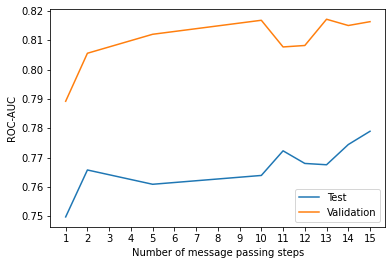

In [37]:
def plot_roc_vs_number_of_message_steps():
  num_message_passing_steps = [1, 2, 5, 10, 11, 12, 13, 14, 15]

  test_roc = [0.7497, 0.765739, 0.760853, 0.763869, 0.772283, 0.767972, 0.767522, 0.7744285589211687, 0.778966]
  valid_roc = [0.789219, 0.805623, 0.812105, 0.816892, 0.807781, 0.808274, 0.817244, 0.8151036115241522, 0.816415]

  plt.plot(num_message_passing_steps, test_roc, label = 'Test')
  plt.plot(num_message_passing_steps, valid_roc, label = 'Validation')

  plt.legend()

  plt.xlabel('Number of message passing steps')
  plt.ylabel('ROC-AUC')

  plt.xticks(range(1, 16))

  index = 0
  for i in num_message_passing_steps:
    print(f'{i} & {round(valid_roc[index] * 100, 2)}\% & {round(test_roc[index] * 100, 2)}\% \\\hline')

    index += 1

plot_roc_vs_number_of_message_steps()

In [38]:
!pip install scipy --upgrade

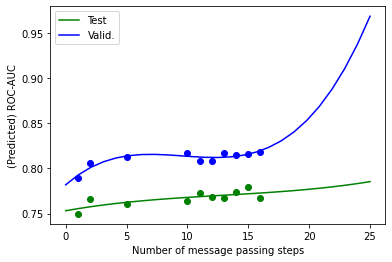

In [39]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np

def plot_expected():
  num_message_passing_steps = [1, 2, 5, 10, 11, 12, 13, 14, 15, 16]

  test_roc = [0.7497, 0.765739, 0.760853, 0.763869, 0.772283, 0.767972, 0.767522, 0.7744285589211687, 0.778966, 0.767022508916476]
  valid_roc = [0.789219, 0.805623, 0.812105, 0.816892, 0.807781, 0.808274, 0.817244, 0.8151036115241522, 0.816415, 0.817769089910641]

  s_test = UnivariateSpline(num_message_passing_steps, test_roc, s = 1000)
  s_valid = UnivariateSpline(num_message_passing_steps, valid_roc, s = 1000)
  xs_test = np.linspace(0, 25, 25)
  ys_test = s_test(xs_test)
  ys_valid = s_valid(xs_test)

  plt.plot(num_message_passing_steps, test_roc, 'o', color = 'green')
  plt.plot(num_message_passing_steps, valid_roc, 'o', color = 'blue')

  plt.plot(xs_test, ys_test, label = 'Test', color = 'green')
  plt.plot(xs_test, ys_valid, label = 'Valid.', color = 'blue')

  plt.xlabel('Number of message passing steps')
  plt.ylabel('(Predicted) ROC-AUC')

  plt.legend()
  plt.show()

plot_expected()

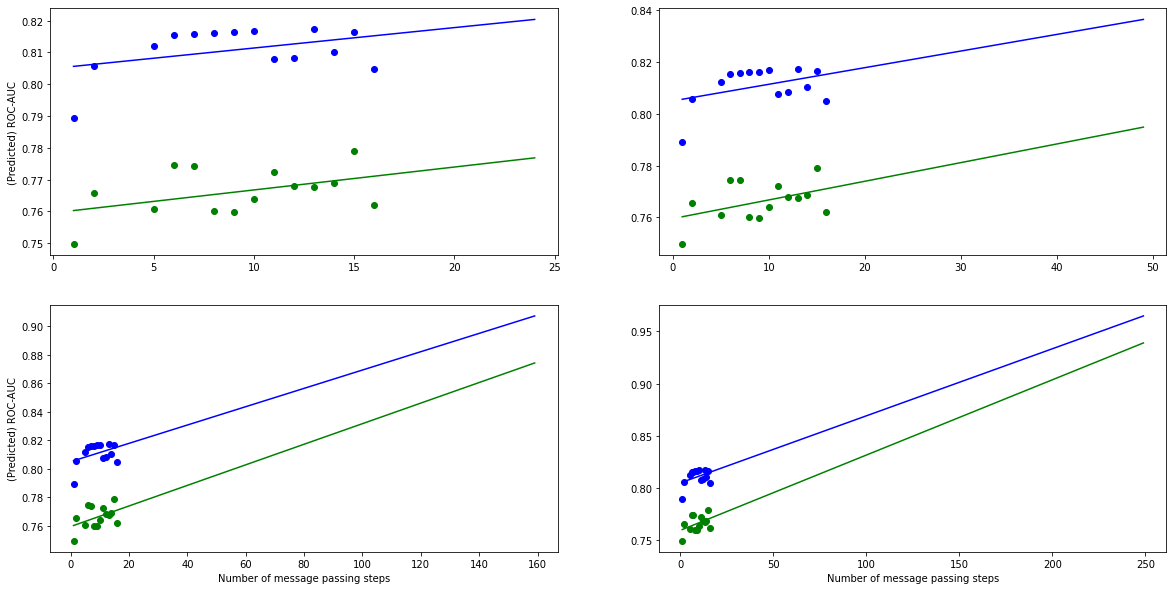

In [69]:
import matplotlib.pyplot as plt    
from sklearn.linear_model import LinearRegression

from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20, 10)

def plot_line_through_points():
  num_message_passing_steps = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

  test_roc = []
  valid_roc = []

  for mp in num_message_passing_steps:
    for index, row in df_batch_size.iterrows():
      if row['Message passing steps'] == mp and row['Epoch'] == 11000:
        test_roc.append(row['ROC test'])
        valid_roc.append(row['ROC eval'])

  num_message_passing_steps = np.array(num_message_passing_steps).reshape(-1, 1)
  test_roc = np.array(test_roc).reshape(-1, 1)
  valid_roc = np.array(valid_roc).reshape(-1, 1)

  fig, axs = plt.subplots(2, 2)
  

  def subplot(index, num_points):
    axs[index[0]][index[1]].plot(np.array(range(1, num_points)).reshape(-1, 1), LinearRegression().fit(num_message_passing_steps, test_roc).predict(np.array(range(1, num_points)).reshape(-1, 1)), color = 'green')
    axs[index[0]][index[1]].plot(np.array(range(1, num_points)).reshape(-1, 1), LinearRegression().fit(num_message_passing_steps, valid_roc).predict(np.array(range(1, num_points)).reshape(-1, 1)), color = 'blue')
    axs[index[0]][index[1]].plot(num_message_passing_steps, test_roc, 'o', color = 'green')
    axs[index[0]][index[1]].plot(num_message_passing_steps, valid_roc, 'o', color = 'blue')

    if index[0] == 1:
      axs[index[0]][index[1]].set_xlabel('Number of message passing steps')

    if index[1] == 0:
      axs[index[0]][index[1]].set_ylabel('(Predicted) ROC-AUC')

  subplot((0, 0), 25)
  subplot((0, 1), 50)
  subplot((1, 0), 160)
  subplot((1, 1), 250)

plot_line_through_points()

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np

def plot_expected_10():
  num_message_passing_steps = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

  test_roc = []
  valid_roc = []

  for mp in num_message_passing_steps:
    for index, row in df_batch_size.iterrows():
      if row['Message passing steps'] == mp and row['Epoch'] == 11000:
        test_roc.append(row['ROC test'])
        valid_roc.append(row['ROC eval'])

  index = 0
  for i in num_message_passing_steps:
    print(f'{i} & {round(valid_roc[index] * 100, 2)}\% & {round(test_roc[index] * 100, 2)}\% \\\hline')

    index += 1

  s_test = UnivariateSpline(num_message_passing_steps, test_roc, s = 0.1)
  s_valid = UnivariateSpline(num_message_passing_steps, valid_roc, s = 0.1)
  xs_test = np.linspace(0, 30, 25)
  ys_test = s_test(xs_test)
  ys_valid = s_valid(xs_test)

  plt.plot(num_message_passing_steps, test_roc, 'o', color = 'green')
  plt.plot(num_message_passing_steps, valid_roc, 'o', color = 'blue')

  plt.plot(xs_test, ys_test, label = 'Test', color = 'green')
  plt.plot(xs_test, ys_valid, label = 'Valid.', color = 'blue')

  plt.ylim(0.725, 1)

  plt.xlabel('Number of message passing steps')
  plt.ylabel('(Predicted) ROC-AUC')

  plt.legend()
  plt.show()

plot_expected_10()

In [ ]:
# import matplotlib.pyplot as plt
# from scipy.interpolate import RBFInterpolator
# import numpy as np

# def plot_expected_1():
#   num_message_passing_steps = [1, 2, 5, 10, 11, 12, 13, 14, 15]

#   test_roc = [0.7497, 0.765739, 0.760853, 0.763869, 0.772283, 0.767972, 0.767522, 0.7744285589211687, 0.778966]
#   valid_roc = [0.789219, 0.805623, 0.812105, 0.816892, 0.807781, 0.808274, 0.817244, 0.8151036115241522, 0.816415]

#   rbf_interpolator = RBFInterpolator([num_message_passing_steps, num_message_passing_steps], [test_roc, valid_roc])

#   xs = np.linspace(0, 25, 25)
#   ys = rbf_interpolator(xs)

#   plt.legend()
#   plt.show()

# plot_expected_1()